In [64]:
import dipy

In [65]:
from dipy.io.image import load_nifti, save_nifti
from dipy.io.gradients import read_bvals_bvecs

In [66]:
from fenics import *
from mshr import *
#from math import pi, sin, cos, sqrt
import math
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import os
import subprocess

In [67]:
fname = 'dMRI_data/ms-ras_data.nii.gz' 
bval_fname = 'dMRI_data/ms-ras.bval' 
bvec_fname = 'dMRI_data/ms-ras.bvec'

data, affine = load_nifti(fname)
bvals, bvecs = read_bvals_bvecs(bval_fname, bvec_fname)
dims = data.shape
print('data.shape (%d, %d, %d, %d)' % dims)

data_float = data.astype(np.float32)

dataMaxVal = int(max(data.flatten()))
dataMinVal = int(min(data.flatten()))

print('b values: ', bvals)
print('b vectors: ', bvecs)

data.shape (104, 104, 72, 99)
b values:  [   0.  700.  700.  700.  700.  700.  700.  700.  700.  700.  700.  700.
  700.  700.  700.  700.  700.  700.  700.  700.  700.    0.  700.  700.
  700.  700.  700.  700.  700.  700.  700.  700. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000.    0. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000.    0. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
    0. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000.]
b vectors:  [[ 0.0000000e+00 -0.0000000e+00  0.0000000e+00]
 [ 2.2293058e-01  4.9968055e-01  8.3703119e-01]
 [-1.7871778e-01  4.9333411e-01  8.5128242e-01]
 [-3.7542525e-01  1.4225766e-01  9.1587037e-01]
 [ 4.1157657e-01  7.2193778e-01  5.5624700e-01]
 [ 1.9853516e-01  9.3616748e-01  2.9012811e-01]
 [ 8.4751403e-01  5.2907634e-01  4.2405690e-02]
 [ 7.39

In [93]:
#Load WM mask
nameStr = 'dMRI_data/fa-tr-thresh.nii.gz'
wm_mask, wm_mask_affine = load_nifti(nameStr)
wm_mask = wm_mask.astype(bool)

In [94]:
parameters['allow_extrapolation'] = True

In [95]:
#Input volume number
k = 1

#B vector
b = 700
b2000_indcs = np.where(bvals==b)
b0_inds = np.where(bvals==0)
b0_ind = b0_inds[0][0]

In [96]:
#To select well distruted (farthes pointing vectors in 3D)
def calc_distances(p0, points):
    return np.minimum(((p0 - points)**2).sum(axis=1), ((-p0 - points)**2).sum(axis=1))
    #return ((p0 - points)**2).sum(axis=1) 
def farthestPts(pts, K):
    farthest_pts = np.zeros((K, 3))
    pts_inds = np.zeros(K)
    #farthest_pts[0] = pts[np.random.randint(len(pts))]
    farthest_pts[0] = pts[1]
    pts_inds[0] = 1
    distances = calc_distances(farthest_pts[0], pts)
    for i in range(1, K):
        farthest_pts[i] = pts[np.argmax(distances)]
        pts_inds[i] = np.argmax(distances)
        distances = np.minimum(distances, calc_distances(farthest_pts[i], pts))
    return farthest_pts, pts_inds
sub_bvecs, sub_indcs = farthestPts(bvecs[bvals==b], k)
print('b sub vectors: ', sub_bvecs)
#print('b sub vector indecs ', sub_indcs)

#Choose true indeces
true_sub_indcs = np.zeros(len(sub_indcs))
for i in range(len(sub_indcs)):
    true_sub_indcs[i] = b2000_indcs[0][int(sub_indcs[i])]
true_sub_indcs = np.append(true_sub_indcs, b0_ind)
sorted_true_sub_indcs = np.sort(true_sub_indcs)
#print('b sub vectors: ', sub_bvecs)
print('sorted b sub vector indeces ', sorted_true_sub_indcs)

b sub vectors:  [[-0.17871778  0.49333411  0.85128242]]
sorted b sub vector indeces  [0. 2.]


In [97]:
# Selecting one b0 and k+7 b700 voxels
sorted_true_sub_indcs = sorted_true_sub_indcs.astype(int)
sub_bvals = bvals[sorted_true_sub_indcs]
print(sub_bvals)

sub_data = data_float[:, :, :, sorted_true_sub_indcs]
print(sub_data.shape)
##Save left volumes as Nifti file
#sub_data_int = sub_data.astype(int)
#subVols = nib.Nifti1Image(sub_data_int, affine=np.eye(4))
#nib.nifti1.save(subVols, os.getcwd()+'{}'.format(r'/cosine_weighted_averaging/sub_vols.nii.gz'))

##Removing input data (1+6 volumes)
#left_data = np.delete(data_float, sub_indcs, axis=3)
#print(left_data.shape)

##Save left volumes as Nifti file
#left_data_int = left_data.astype(int)
#predictedVols = nib.Nifti1Image(left_data_int, affine=np.eye(4))
#nib.nifti1.save(predictedVols, os.getcwd()+'{}'.format(r'/cosine_weighted_averaging/left_vols.nii.gz'))

[  0. 700.]
(104, 104, 72, 2)


In [98]:
##Registration
#b0_ind = np.where(sub_bvals==0)[0]
#regis_sub_data = subprocess.run(["eddy_correct", "cosine_weighted_averaging/sub_vols.nii.gz", "cosine_weighted_averaging/registered_data/sub_data_lowb-corrected.nii.gz", str(b0_ind[0])])
#print("The exit code was: %d" % regis_sub_data.returncode)

In [99]:
#Load registrated data
#nameStr = 'LH_all_voxels/registered_data/kFrame_correct17.nii.gz'     
#sub_regis_data, sub_regis_affine = load_nifti(nameStr)
#dims_sub = sub_regis_data.shape
#print('data.shape (%d, %d, %d, %d)' % sub_regis_data.shape)
#print('Type: ', sub_regis_data.dtype)

In [100]:
#Volume Index to predict
#nextIter_sub_bvecs, nextIter_sub_indcs = closestPts(bvecs[bvals==b], k+1)
nextIter_sub_bvecs, nextIter_sub_indcs = farthestPts(bvecs[bvals==b], k+1)
nextIter_true_sub_indcs = np.zeros(len(nextIter_sub_indcs))
for i in range(len(nextIter_sub_indcs)):
    nextIter_true_sub_indcs[i] = b2000_indcs[0][int(nextIter_sub_indcs[i])]
nextIter_true_sub_indcs = np.append(nextIter_true_sub_indcs, b0_ind)
sorted_nextIter_true_sub_indcs = np.sort(nextIter_true_sub_indcs)
print('b sub vector indecs ', sorted_nextIter_true_sub_indcs)
nextIter_sub_indcs = sorted_nextIter_true_sub_indcs.astype(int)
    
inter_sub_indcs = [i for i in sorted_nextIter_true_sub_indcs if i not in sorted_true_sub_indcs]
if len(inter_sub_indcs) != 0: 
    left_indcs = inter_sub_indcs[0]
else:
    left_indcs = np.arange(data.shape[3])
    left_indcs = np.delete(left_indcs, sorted_true_sub_indcs)
    print(left_indcs)
    left_indcs = left_indcs[0]
left_indcs = left_indcs.astype(int)
print("Predicted volume: ", left_indcs)

b sub vector indecs  [ 0.  2. 37.]
Predicted volume:  37


In [101]:
#center = Point(0.0, 0.0, 0.0)
#sphere = Sphere(center,1.0)
#mesh = generate_mesh(sphere,5) # 20 specify the resolution of the mesh
#plot(mesh)

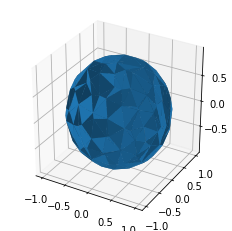

In [102]:
# Mesh and function space
#sphere = Sphere(Point(0.0, 0.0, 0.0), 1.0)
#vmesh = generate_mesh(sphere, 5)
#mesh = BoundaryMesh(vmesh, "exterior")
#plot(mesh)

#mesh = Mesh('LH/mesh.xml')
mesh = Mesh('LH/mesh_on_sphere_myself_b700_del_fib0_1.xml')
plot(mesh)

In [103]:
for ind in nextIter_sub_indcs:
    print(ind)

0
2
37


In [104]:
sub_indcs

array([1.])

In [105]:
left_indcs

37

In [106]:
# Optimization options for the form compiler
parameters["form_compiler"]["cpp_optimize"] = True
parameters["form_compiler"]["optimize"] = True

In [107]:
# Make mesh ghosted for evaluation of DG terms
parameters["ghost_mode"] = "shared_facet"

In [108]:
bvec_volPredict = bvecs[left_indcs]
lh_coefs = np.zeros(len(sorted_true_sub_indcs))

for l in range(len(sorted_true_sub_indcs)):
    if sorted_true_sub_indcs[l] != 0:
        V = FunctionSpace(mesh, "P", 1)
        # get coordinates of DOFs
        dof_coords = V.tabulate_dof_coordinates()
        
        bcs = []
        for ind in sub_indcs:
            if ind!=0:
                if ind==sub_indcs[l]:
                    # find nearest DOF:
                    dof = np.argmin(np.linalg.norm(dof_coords - bvecs[ind], axis=1))
                    #print('dof {}, x = {}'.format(dof, dof_coords[dof]))
                    dof_sym = np.argmin(np.linalg.norm(dof_coords + bvecs[ind], axis=1))
                    #print('dof {}, x = {}'.format(dof_sym, dof_coords[dof_sym])) 

                    # now define a DirichletBC at that point
                    bcs.extend([DirichletBC(V, Constant(1.0),
                                     'near(x[0], {x}) && near(x[1], {y}) && near(x[2], {z})'.format(x=dof_coords[dof][0], y=dof_coords[dof][1], z=dof_coords[dof][2]),
                                     'pointwise'),
                                DirichletBC(V, Constant(1.0),
                                     'near(x[0], {x}) && near(x[1], {y}) && near(x[2], {z})'.format(x=dof_coords[dof_sym][0], y=dof_coords[dof_sym][1], z=dof_coords[dof_sym][2]),
                                     'pointwise')])
                else:
                    # find nearest DOF:
                    dof = np.argmin(np.linalg.norm(dof_coords - bvecs[ind], axis=1))
                    #print('dof {}, x = {}'.format(dof, dof_coords[dof]))
                    dof_sym = np.argmin(np.linalg.norm(dof_coords + bvecs[ind], axis=1))
                    #print('dof {}, x = {}'.format(dof_sym, dof_coords[dof_sym])) 

                    # now define a DirichletBC at that point
                    bcs.extend([DirichletBC(V, Constant(0.0),
                                     'near(x[0], {x}) && near(x[1], {y}) && near(x[2], {z})'.format(x=dof_coords[dof][0], y=dof_coords[dof][1], z=dof_coords[dof][2]),
                                     'pointwise'),
                                DirichletBC(V, Constant(0.0),
                                     'near(x[0], {x}) && near(x[1], {y}) && near(x[2], {z})'.format(x=dof_coords[dof_sym][0], y=dof_coords[dof_sym][1], z=dof_coords[dof_sym][2]),
                                     'pointwise')])
                    
        # Define trial and test functions
        u = TrialFunction(V)
        v = TestFunction(V)

        # Define normal component, mesh size and right-hand side
        h = CellDiameter(mesh)
        h_avg = (h('+') + h('-'))/2.0
        n = FacetNormal(mesh)
        f = Constant(0.0)

        # Penalty parameter
        alpha = Constant(8.0)
        # Define bilinear form
        a = inner(div(grad(u)), div(grad(v)))*dx \
          - inner(avg(div(grad(u))), jump(grad(v), n))*dS \
          - inner(jump(grad(u), n), avg(div(grad(v))))*dS \
          + alpha/h_avg*inner(jump(grad(u),n), jump(grad(v),n))*dS

        # Define linear form
        L = f*v*dx

        # Solve variational problem
        w = Function(V)
        solve(a == L, w, bcs)
        
        lh_coefs[l] = w(bvec_volPredict)
        print(lh_coefs[l])
    else:
        sub_indcs[l] = 0

0.0


In [109]:
lh_coefs

array([0., 0.])

In [110]:
np.sum(lh_coefs)

0.0

In [ ]:
inpaintedImg_3D = np.zeros((dims[0], dims[1], dims[2]))

for i in range(len(sub_indcs)):
    inpaintedImg_3D = inpaintedImg_3D + lh_coefs[i]*data_float[...,sub_indcs[i]]
inpaintedImg_3D = inpaintedImg_3D/np.sum(lh_coefs)

In [ ]:
min(inpaintedImg_3D.flatten())

In [ ]:
bvec_volPredict

In [ ]:
ni_img = nib.Nifti1Image(inpaintedImg_3D, affine=affine)
nib.save(ni_img, "fast_qspace_BH_volume_image_on_sphere_9_dely_P1.nii")

In [ ]:
array_u = nodal_values_u = w.vector()
vertex_values_u = w.compute_vertex_values()

In [ ]:
print(array_u)

In [ ]:
for i in range(len(array_u)):
    print(array_u[i])

In [ ]:
min(array_u)

In [ ]:
len(array_u)

In [ ]:
bvecs[1][0]

In [ ]:
bvecs[1][2]

In [ ]:
data_float[63,54,30,1]

In [ ]:
data_float[63,54,30,14]

In [ ]:
data_float[63,54,30,17]

In [ ]:
data_float[63,54,30,20]

In [ ]:
data_float[63,54,30,22]

In [ ]:
data_float[63,54,30,29]

In [ ]:
#error_L2 = errornorm(u_D, w, 'L2')
#vertex_values_u_D = u_D.compute_vertex_values(mesh)
#vertex_values_u = w.compute_vertex_values(mesh)
#error_max = np.max(np.abs(vertex_values_u_D - vertex_values_u))
#print(error_max)
#print(error_L2)

In [ ]:
bvecs[27]

In [ ]:
x_point = Point(*[bvecs[27]])
mesh.bounding_box_tree().compute_first_entity_collision(x_point)

In [ ]:
#mesh.bounding_box_tree().compute_closest_point(x_point)

In [ ]:
inpaintedImg_3D.shape

In [ ]:
max(inpaintedImg_3D.flatten())

In [ ]:
for ind in sub_indcs:
    if ind!=0:
        # find nearest DOF:
        dof = np.argmin(np.linalg.norm(dof_coords - bvecs[ind], axis=1))
        print('dof {}, x = {}'.format(dof, dof_coords[dof]))
        dof_sym = np.argmin(np.linalg.norm(dof_coords + bvecs[ind], axis=1))
        print('dof {}, x = {}'.format(dof_sym, dof_coords[dof_sym])) 

In [ ]:
bvecs

In [ ]:
for ind in sub_indcs:
    print(ind)